In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For the choropleth 
import plotly.offline as py 
import plotly.graph_objs as go
import plotly.tools as tls 

# For the SIR Model 
from scipy.integrate import odeint 

%matplotlib inline

In [3]:
df = pd.read_csv("csse_covid_19_time_series/data/time_series_covid19_confirmed_US.csv",index_col = 'Province_State')

In [4]:
df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Country_Region,Lat,Long_,Combined_Key,...,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
Province_State,,,,,,,,,,,,,,,,,,,,,
American Samoa,16,AS,ASM,16,60.0,NaN,US,-14.2710,-170.1320,"American Samoa, US",...,0,0,0,0,0,0,0,0,0,0
Guam,316,GU,GUM,316,66.0,NaN,US,13.4443,144.7937,"Guam, US",...,154,154,154,154,165,165,165,166,166,167
Northern Mariana Islands,580,MP,MNP,580,69.0,NaN,US,15.0979,145.6739,"Northern Mariana Islands, US",...,21,21,21,21,22,22,22,22,22,22
Puerto Rico,630,PR,PRI,630,72.0,NaN,US,18.2208,-66.5901,"Puerto Rico, US",...,2646,2710,2805,2866,2913,3030,3100,3189,3260,3324
Virgin Islands,850,VI,VIR,850,78.0,NaN,US,18.3358,-64.8963,"Virgin Islands, US",...,69,69,69,69,69,69,69,69,69,69


### Did Covid data change after the lockdown?
In this hypothesis we are going to find out if the covid data changed after the lockdown was imposed in different states.

The lockdown was imposed in California on 20th march. So we are going to use the covid data before the lockdown and after the lockdown to check if the data has changed or not. For this purpose we are going to use the right tailed paired t test to see the change in the data before the lockdown and after the lock down.

## Data Cleaning

In [5]:
df.isna().sum()

UID                0
iso2               0
iso3               0
code3              0
FIPS              10
Admin2             7
Country_Region     0
Lat                0
Long_              0
Combined_Key       0
1/22/20            0
1/23/20            0
1/24/20            0
1/25/20            0
1/26/20            0
1/27/20            0
1/28/20            0
1/29/20            0
1/30/20            0
1/31/20            0
2/1/20             0
2/2/20             0
2/3/20             0
2/4/20             0
2/5/20             0
2/6/20             0
2/7/20             0
2/8/20             0
2/9/20             0
2/10/20            0
                  ..
4/27/20            0
4/28/20            0
4/29/20            0
4/30/20            0
5/1/20             0
5/2/20             0
5/3/20             0
5/4/20             0
5/5/20             0
5/6/20             0
5/7/20             0
5/8/20             0
5/9/20             0
5/10/20            0
5/11/20            0
5/12/20            0
5/13/20      

In [6]:
df['FIPS'].unique()

array([6.0000e+01, 6.6000e+01, 6.9000e+01, ..., 9.0056e+04, 9.9999e+04,
              nan])

In [7]:
#Since, the FIPS column is of no use for inference. We can Drop it.
df2 = df.drop(['FIPS'],axis=1)
df3 = df2.drop(['Admin2'],axis=1)
df4 = df3.drop(['UID'],axis=1)
df5 = df4.drop(['code3'],axis=1)

In [8]:
drop_rows = ["iso3", "iso2", "Combined_Key", "Country_Region", "Lat", "Long_"]               # Removing useless columns, such as province codes
ht_df = df5.drop(drop_rows, axis = 1)
ht_df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
Province_State,,,,,,,,,,,,,,,,,,,,,
American Samoa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Guam,0,0,0,0,0,0,0,0,0,0,...,154,154,154,154,165,165,165,166,166,167
Northern Mariana Islands,0,0,0,0,0,0,0,0,0,0,...,21,21,21,21,22,22,22,22,22,22
Puerto Rico,0,0,0,0,0,0,0,0,0,0,...,2646,2710,2805,2866,2913,3030,3100,3189,3260,3324
Virgin Islands,0,0,0,0,0,0,0,0,0,0,...,69,69,69,69,69,69,69,69,69,69


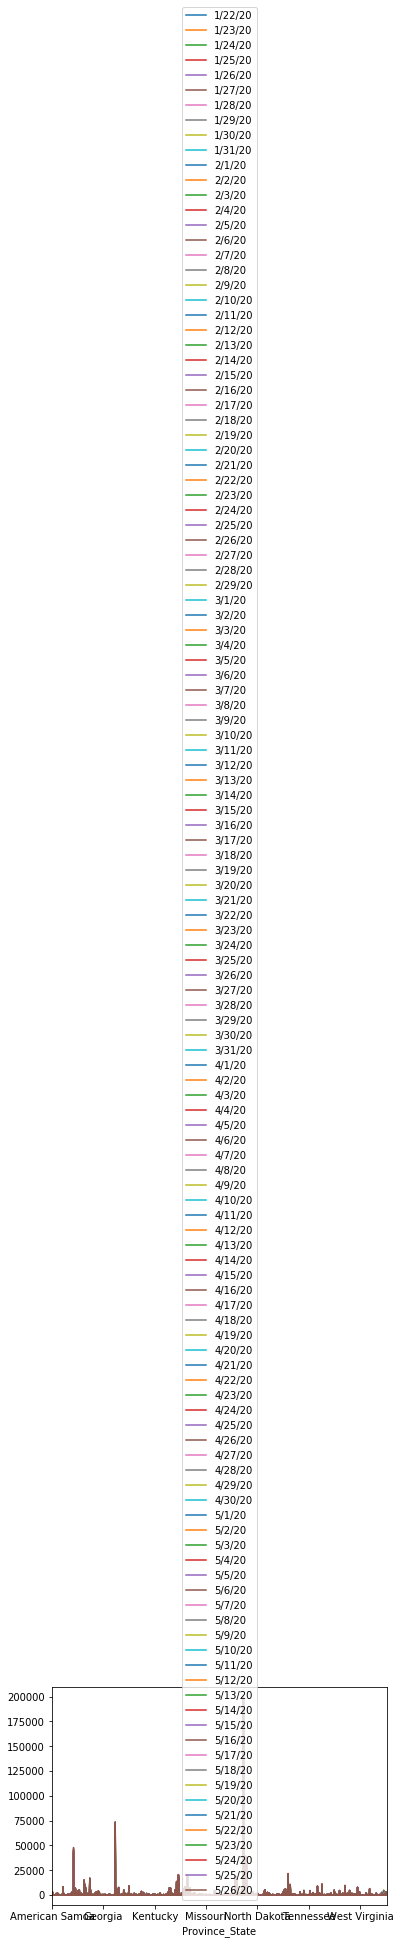

In [9]:
# 
import matplotlib.pyplot as plt
sns.set_style(style = {'figsize': (16, 8)})

ht_df.plot()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Grouper
from datetime import datetime, timedelta
from math import sqrt

CAdata_raw = ht_df.loc["California"]
CAdata_raw.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
Province_State,,,,,,,,,,,,,,,,,,,,,
California,0,0,0,0,0,0,0,0,0,0,...,2392,2457,2522,2560,2609,2708,2760,2847,2874,2986
California,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
California,0,0,0,0,0,0,0,0,0,0,...,9,10,10,10,10,10,10,10,10,10
California,0,0,0,0,0,0,0,0,0,0,...,22,24,26,30,31,34,34,34,34,40
California,0,0,0,0,0,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,14


In [11]:
CAdata_raw.loc['Total']= CAdata_raw.sum()

/Users/scarlett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [12]:
CAdata_raw.tail()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
Province_State,,,,,,,,,,,,,,,,,,,,,
California,0,0,0,0,0,0,0,0,0,0,...,184,184,185,185,185,186,190,190,194,198
California,0,0,0,0,0,0,0,0,0,0,...,25,26,28,28,28,28,28,28,28,28
California,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
California,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Total,0,0,0,0,2,2,2,2,2,3,...,80166,81457,83752,85997,88031,90252,92539,94020,96400,99387


In [13]:
CAdata = CAdata_raw.loc['Total']
CAdata

1/22/20        0
1/23/20        0
1/24/20        0
1/25/20        0
1/26/20        2
1/27/20        2
1/28/20        2
1/29/20        2
1/30/20        2
1/31/20        3
2/1/20         3
2/2/20         3
2/3/20         6
2/4/20         6
2/5/20         6
2/6/20         6
2/7/20         6
2/8/20         6
2/9/20         6
2/10/20        6
2/11/20        7
2/12/20        7
2/13/20        8
2/14/20        8
2/15/20        8
2/16/20        8
2/17/20        8
2/18/20        8
2/19/20        8
2/20/20        8
           ...  
4/27/20    44966
4/28/20    46164
4/29/20    48747
4/30/20    50130
5/1/20     52026
5/2/20     53347
5/3/20     54903
5/4/20     55884
5/5/20     58456
5/6/20     60616
5/7/20     62148
5/8/20     63779
5/9/20     66558
5/10/20    67600
5/11/20    69329
5/12/20    70978
5/13/20    72798
5/14/20    74871
5/15/20    76693
5/16/20    78725
5/17/20    80166
5/18/20    81457
5/19/20    83752
5/20/20    85997
5/21/20    88031
5/22/20    90252
5/23/20    92539
5/24/20    940

In [78]:

# data of the week before the lockdown that is from 12th march to 19th march

# lockdown_date = datetime.strptime("2020-03-20", "%Y-%m-%d").date()
lockdown_date = pd.Timestamp("3/20/20")

#date after three weeks of lockdown 
# a_lockdown_begindate = lockdown_date + timedelta(days=14)
# a_lockdown_enddate = lockdown_date + timedelta(days=21)
# lockdown_begindate = lockdown_date + timedelta(days=0)
# lockafter2_begindate = lockdown_date + timedelta(days=21)
# lockafter2_enddate = lockdown_date + timedelta(days=28)
# lockafter3_begindate = lockdown_date + timedelta(days=28)
# lockafter3_enddate = lockdown_date + timedelta(days=35)

before_ld = CAdata.loc['3/5/20':'3/20/20']
print(before_ld)

lock_d1 = CAdata.loc['3/20/20':'4/3/20']
print(lock_d1)

lock_d2 = CAdata.loc['4/3/20':'4/10/20']
print(lock_d2)

lock_d3 = CAdata.loc['4/10/20':'4/17/20']
print(lock_d3)

lock_d4 = CAdata.loc['4/17/20':'4/24/20']
print(lock_d4)

3/5/20       51
3/6/20       59
3/7/20       81
3/8/20       95
3/9/20      101
3/10/20     144
3/11/20     178
3/12/20     221
3/13/20     281
3/14/20     372
3/15/20     373
3/16/20     557
3/17/20     700
3/18/20     828
3/19/20    1005
3/20/20    1243
Name: Total, dtype: int64
3/20/20     1243
3/21/20     1405
3/22/20     1646
3/23/20     2108
3/24/20     2538
3/25/20     2998
3/26/20     3899
3/27/20     4657
3/28/20     5095
3/29/20     5852
3/30/20     7138
3/31/20     8210
4/1/20      9399
4/2/20     10773
4/3/20     12004
Name: Total, dtype: int64
4/3/20     12004
4/4/20     12837
4/5/20     15034
4/6/20     16019
4/7/20     17351
4/8/20     18897
4/9/20     19710
4/10/20    21081
Name: Total, dtype: int64
4/10/20    21081
4/11/20    21706
4/12/20    22795
4/13/20    23931
4/14/20    25356
4/15/20    26686
4/16/20    27677
4/17/20    29157
Name: Total, dtype: int64
4/17/20    29157
4/18/20    30491
4/19/20    31431
4/20/20    33686
4/21/20    35465
4/22/20    37344
4/23/20    

In [59]:
before_ld

3/5/20       51
3/6/20       59
3/7/20       81
3/8/20       95
3/9/20      101
3/10/20     144
3/11/20     178
3/12/20     221
3/13/20     281
3/14/20     372
3/15/20     373
3/16/20     557
3/17/20     700
3/18/20     828
3/19/20    1005
3/20/20    1243
Name: Total, dtype: int64

In [72]:
before_ld_d = before_ld.diff().fillna(0)


In [74]:
lock_d1_d = lock_d1.diff().fillna(0)
lock_d1_d['3/20/20'] = 1243
lock_d1_d 

3/20/20    1243.0
3/21/20     162.0
3/22/20     241.0
3/23/20     462.0
3/24/20     430.0
3/25/20     460.0
3/26/20     901.0
3/27/20     758.0
3/28/20     438.0
3/29/20     757.0
3/30/20    1286.0
3/31/20    1072.0
4/1/20     1189.0
4/2/20     1374.0
4/3/20     1231.0
Name: Total, dtype: float64

In [75]:
lock_d2_d = lock_d2.diff().fillna(0)
lock_d2_d['4/3/20'] = 1231.0
lock_d2_d 

4/3/20     1231.0
4/4/20      833.0
4/5/20     2197.0
4/6/20      985.0
4/7/20     1332.0
4/8/20     1546.0
4/9/20      813.0
4/10/20    1371.0
Name: Total, dtype: float64

In [76]:
lock_d3_d = lock_d3.diff().fillna(0)
lock_d3_d['4/10/20'] = 1371.0
lock_d3_d 

4/10/20    1371.0
4/11/20     625.0
4/12/20    1089.0
4/13/20    1136.0
4/14/20    1425.0
4/15/20    1330.0
4/16/20     991.0
4/17/20    1480.0
Name: Total, dtype: float64

In [80]:
lock_d4_d = lock_d4.diff().fillna(0)
lock_d4_d['4/17/20'] = 1480.0
lock_d4_d 

4/17/20    1480.0
4/18/20    1334.0
4/19/20     940.0
4/20/20    2255.0
4/21/20    1779.0
4/22/20    1879.0
4/23/20    2217.0
4/24/20    1794.0
Name: Total, dtype: float64

In [81]:
from statsmodels.stats.weightstats import ttest_ind
from scipy import stats

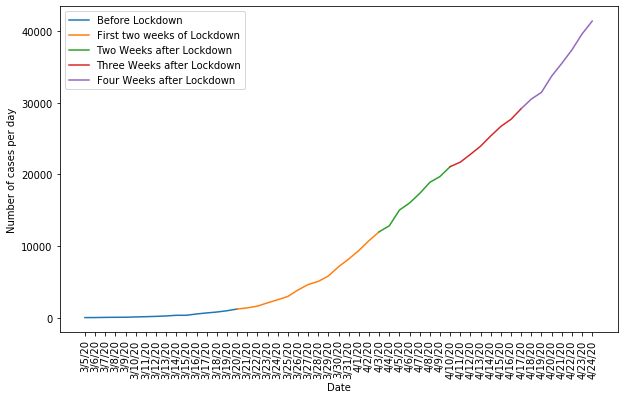

In [66]:
# plotting the number of deaths weekly
%matplotlib inline

plt.figure(figsize = (10,6))
plt.plot(before_ld,label = 'Before Lockdown')
plt.plot(lock_d1,label = 'First two weeks of Lockdown')
plt.plot(lock_d2,label = 'Two Weeks after Lockdown')
plt.plot(lock_d3, label = 'Three Weeks after Lockdown')
plt.plot(lock_d4, label = 'Four Weeks after Lockdown')

# lockdownCases = CAdata[CAdata['date']==lockdown_date]['new_deaths']
# plt.scatter(lockdown_date,0,label = 'LockDown Announced date',s = 100)
plt.xticks(rotation = 90)
plt.xlabel("Date")
plt.ylabel("Number of cases per day")
plt.legend()
plt.show()

In [47]:
# performing the right tailed paired t-test
def T_test(X,Y):
    D = X-Y

    # Plotting the difference of the X and Y
    mu, std = norm.fit(D)
    plt.hist(D, bins=7, density=True, alpha=0.6, color='b')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Plot of Difference of X and Y. Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()
    
    n = len(D)
    sample_std = np.std(D)
    # Calculating the t-statistic 
    t_statistic = ((np.mean(D)/sample_std)*sqrt(n))


    # t_alpha (right tailed t test) for df = 6 and significant value of 0.05. This is obatined from the T-table.
    t_alpha = 1.943

    if t_statistic > t_alpha:
        print('The null hypothesis is rejected')
    else:
        print('The null hypothesis is accepted')
    print('The T-statistic value = ', str(t_statistic))
    print('The t_alpha value for 95% statistical confidence for right tailed test = ' + str(t_alpha))
    

print("Test 1 \n")
print("T test for finding if the number of cases two weeks after the lockdown increased or decreased/remained equal when compared to the cases before the lockdown")
print("H0 = The number of cases two weeks after the lockdown increased")
print("H1 = The number of cases two weeks after the lockdown decreased or remained equal")

X1 = np.array(before_ld)
Y1 = np.array(lock_d1)
T_test(X1,Y1)

print("----------------------------------------------------------------------------------------------------------\n")

print("Test 2 \n")
print("T test for finding if the number of cases three weeks after the lockdown increased or decreased/remained equal when compared to the cases two weeks after the lockdown")
print("H0 = The number of cases three weeks after the lockdown increased when compared to the cases two weeks after the lockdown ")
print("H1 = The number of cases three weeks after the lockdown decreased or remained equal when compared to the cases two weeks after the lockdown")

X2 = np.array(before_ld)
Y2 = np.array(lock_d2)
T_test(X2,Y2)

print("----------------------------------------------------------------------------------------------------------")

print("Test 3 \n")
print("T test for finding if the number of cases four weeks after the lockdown increased or decreased/remained equal when compared to the cases three weeks after the lockdown")
print("H0 = The number of cases four weeks after the lockdown increased when compared to the cases three weeks after the lockdown ")
print("H1 = The number of cases four weeks after the lockdown decreased or remained equal when compared to the cases three weeks after the lockdown")

X3 = np.array(before_ld)
Y3 = np.array(lock_d3)
T_test(X3,Y3)

print("----------------------------------------------------------------------------------------------------------")

print("Test 4 \n")
print("T test for finding if the number of deaths two weeks after the lockdown increased or decreased/remained equal when compared to the deaths before the lockdown")
print("H0 = The number of deaths two weeks after the lockdown increased")
print("H1 = The number of deaths two weeks after the lockdown decreased or remained equal")


X4 = np.array(before_ld)
Y4 = np.array(lock_d4)
T_test(X1,Y1)

print("----------------------------------------------------------------------------------------------------------")




Test 1 

T test for finding if the number of cases two weeks after the lockdown increased or decreased/remained equal when compared to the cases before the lockdown
H0 = The number of cases two weeks after the lockdown increased
H1 = The number of cases two weeks after the lockdown decreased or remained equal


ValueError: operands could not be broadcast together with shapes (16,) (14,) 

In [48]:
tstat, pvalue, ddof = ttest_ind(
                                before_ld_d,
                                lock_d1_d,
                                alternative="larger",
                                usevar="pooled"
)

In [49]:
print(ddof)

28.0


In [50]:
before_ld_d

3/5/20       0.0
3/6/20       8.0
3/7/20      22.0
3/8/20      14.0
3/9/20       6.0
3/10/20     43.0
3/11/20     34.0
3/12/20     43.0
3/13/20     60.0
3/14/20     91.0
3/15/20      1.0
3/16/20    184.0
3/17/20    143.0
3/18/20    128.0
3/19/20    177.0
3/20/20    238.0
Name: Total, dtype: float64

In [51]:
print(tstat)

-6.23896540192877


In [52]:
pvalue

0.9999995177748283

In [53]:
from scipy import stats
1 - stats.t.cdf(tstat, df=ddof)

0.9999995177748283

In [54]:
tstat, pvalue, ddof = ttest_ind(
                                before_ld_d,
                                lock_d2_d,
                                alternative="larger",
                                usevar="pooled"
)
pvalue

0.9999991772446781

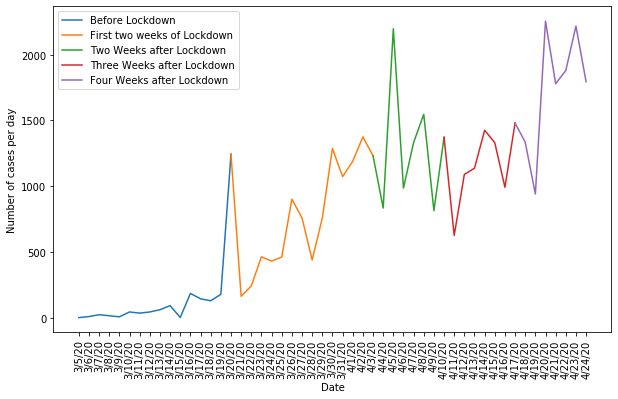

In [82]:
# plotting the number of deaths weekly
%matplotlib inline

plt.figure(figsize = (10,6))
plt.plot(before_ld_d,label = 'Before Lockdown')
plt.plot(lock_d1_d,label = 'First two weeks of Lockdown')
plt.plot(lock_d2_d,label = 'Two Weeks after Lockdown')
plt.plot(lock_d3_d, label = 'Three Weeks after Lockdown')
plt.plot(lock_d4_d, label = 'Four Weeks after Lockdown')

# lockdownCases = CAdata[CAdata['date']==lockdown_date]['new_deaths']
# plt.scatter(lockdown_date,0,label = 'LockDown Announced date',s = 100)
plt.xticks(rotation = 90)
plt.xlabel("Date")
plt.ylabel("Number of cases per day")
plt.legend()
plt.show()

In [69]:
lock_d3_d.iloc[1:]

4/11/20     625.0
4/12/20    1089.0
4/13/20    1136.0
4/14/20    1425.0
4/15/20    1330.0
4/16/20     991.0
4/17/20    1480.0
Name: Total, dtype: float64

In [70]:
lock_d4_d.iloc[1:]

4/19/20     940.0
4/20/20    2255.0
4/21/20    1779.0
4/22/20    1879.0
4/23/20    2217.0
4/24/20    1794.0
Name: Total, dtype: float64